In [2]:
using Distributions, Random, JuMP, Ipopt  
using LinearAlgebra, Plots, Revise
includet("experiment.jl")

┌ Info: Recompiling stale cache file /Users/evanmunro/.julia/compiled/v1.1/Revise/M1Qoh.ji for Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1184


In [4]:
dg= Uniform(1,3) 
b_optimal = true_Frankel_estimate(dg) 

bn = [0,1]
b=[0,1]
steps = 750 
bplot = zeros(steps+1)
bnplot = zeros(steps+1)
bplot[1] = b[2] 
bnplot[1] = bn[2] 
for i in 1:steps
    bn = update_naive(bn,dg)
    b = update_beta(b,dg)
    bplot[i+1] =  b[2] 
    bnplot[i+1] = bn[2]
end
println(b)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equ

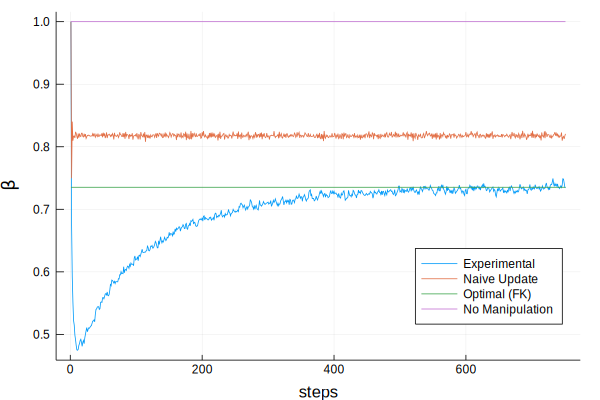

In [5]:
labels = ["Experimental","Naive Update","Optimal (FK)","No Manipulation"]
plot(bplot,legend=:bottomright,label=labels)
plot!(bnplot,label=labels)
plot!(zeros(length(bplot)).+b_optimal[2],xlabel="steps",ylabel="\\beta",label=labels)
plot!(zeros(length(bplot)).+1,label=labels)
#savefig("optimal_convg.pdf")

In [3]:

function update_naive(b,dg,n=100000)
    y,x,gamma = generate_sample_Frankel(dg,b[2],n)  
    return linReg(y,x)
end

function generate_sample_Frankel(dg,betas,n)
    gamma = rand(dg,n) 
    m= 1 
    z = rand(Normal(),n) 
    e = rand(Normal(),n)
    x = z .+ m.*gamma.*betas
    y = z .+ e
    return y, x, gamma
end
#use experiment to update beta 
function update_beta(b,dg,alpha=0.02,n=100000)
    step = 0.03
    perturb = rand([-1,1],n).*step
    y,x,gamma = generate_sample_Frankel(dg,b[2] .+ perturb,n)
    yhat = b[1].+(b[2].+perturb).*x
    ehat = y .- yhat 
    dhat = linReg(ehat.^2, perturb)[2] 
    #xhat = linReg(x,perturb)[2]
    ghat0 = 2/n*sum((y .- yhat))
    ghat1 = dhat 
    bhat0 = b[1] + alpha*ghat0
    bhat1 = b[2] - alpha*ghat1
    return [ bhat0, bhat1 ] 
end

function linReg(y,x)
    x1 = [ones(length(y)) x ]#x.^2]
    m1 = inv(x1'*x1)*x1'*y 
    return m1
end 

function true_Frankel_estimate(dg,m=1,n=10000) 
    gamma = rand(dg,n)
    z = rand(Normal(),n) 
    e = rand(Normal(0,0.5),n)
    y = z .+ e
    model =  Model(with_optimizer(Ipopt.Optimizer))
    @variable(model,b1)
    @variable(model,b0)
    @NLobjective(model,Min,1/n*sum((y[i] - b1*(z[i]+m*gamma[i]*b1)-b0)^2 for i in 1:n))
    optimize!(model)
    return [value(b0) value(b1)]
end 

true_Frankel_estimate (generic function with 3 methods)

In [ ]:
x = [ones(length(x)) x ]

In [ ]:
step = b[2]/5
perturb = rand(Uniform(-1,1),1000).*step
y,x = generate_sample_Frankel(b[2] .+ perturb,1000)
yhat = b[1].+b[2].*x
dhat = localDeriv(x,perturb)
println(mean(dhat))

In [ ]:
println(var(dhat))

0.7162978701990245